<a href="https://colab.research.google.com/github/sadat1971/sadat1971.github.io/blob/main/Neural_Network_from_scratch_Karpathy_style_(Part_2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Visualizing tanh

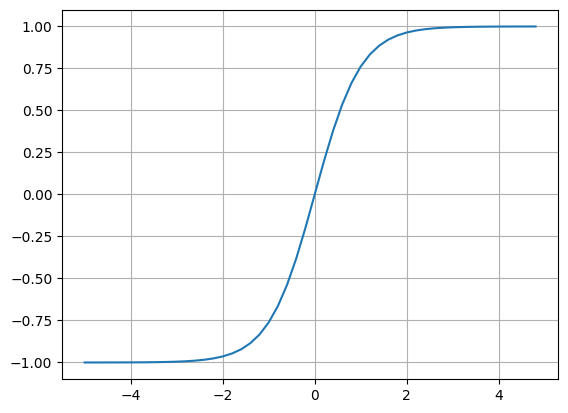

In [2]:
plt.plot(np.arange(-5,5,.2), np.tanh(np.arange(-5,5,.2)))
plt.grid()

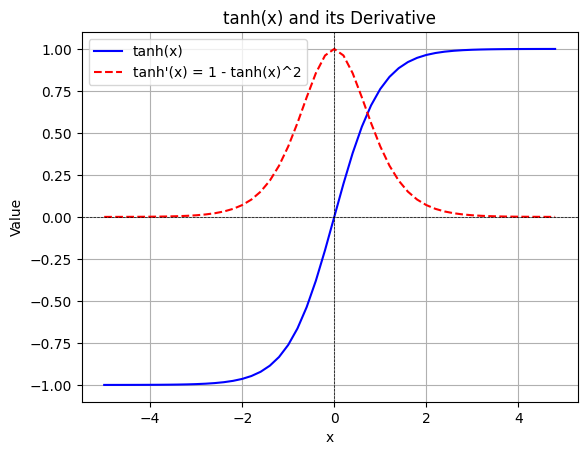

In [3]:

# Define the x values
x = np.arange(-5, 5, 0.2)

# Calculate tanh(x) and its derivative
tanh_x = np.tanh(x)
tanh_derivative = 1 - np.tanh(x)**2

# Plot tanh(x) and its derivative
plt.plot(x, tanh_x, label='tanh(x)', color='blue')
plt.plot(x, tanh_derivative, label="tanh'(x) = 1 - tanh(x)^2", color='red', linestyle='--')

# Add labels and legend
plt.xlabel('x')
plt.ylabel('Value')
plt.title('tanh(x) and its Derivative')
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')
plt.axvline(0, color='black', linewidth=0.5, linestyle='--')
plt.legend()
plt.grid(True)


## Building a network

In [4]:
class Value:
    def __init__(self, data, _ancestors=(), _op='', label='', grad=0):
        self.data = data  # The original numeric value
        self._prev = set(_ancestors)  # Ancestor nodes in the computation graph
        self._op = _op  # Operation that created this node
        self.label = label  # Optional label for visualization
        self.grad = grad
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data}, label={self.label})"  # String representation of the Value object

    def __add__(self, other):
        # Overload '+' operator to create a new Value node
        ## The problem is, this way of addition will not enable us to add a value and an integer. So we do this:
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self,other), '+')

        def _backward():
            self.grad += 1.0*out.grad
            other.grad += 1.0*out.grad

        out._backward = _backward
        return out

    def __neg__(self):
        # Overload unary '-' operator to negate the value
        return self * -1

    def __sub__(self, other):
        # Overload '-' operator as addition of a negated value
        return self + (-other)

    def __mul__(self, other):
        # Overload '*' operator to create a new Value node
        ## The problem is, this way of multiplication will not enable us to add a value and an integer. So we do this:
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self,other), '*')
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __pow__(self, other):
        # Overload '**' operator for power with scalar exponents
        assert isinstance(other, (int, float)), "only suporting int or float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data **(other-1)) * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        n = self.data
        t = (math.exp(2*n)-1)/(math.exp(2*n) + 1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1-t**2) * out.grad

        out._backward = _backward
        return out

    def __truediv__(self, other):
        # Overload '/' operator as multiplication by reciprocal
        return self * other**-1

    def __radd__(self, other):
        # Support reverse addition for non-Value types
        return self + other

    def __rmul__(self, other):
        # Support reverse multiplication for non-Value types
        return self * other

    def backward(self):
      """
      Computes the gradients of all nodes in the computation graph
      using reverse-mode automatic differentiation.
      """
      topo = []
      visited = set()
      def build_topo(v):
          if v not in visited:
              visited.add(v)
              for child in v._prev:
                  build_topo(child)
              topo.append(v)

      build_topo(self)
      self.grad=1.0
      for node in reversed(topo):
          node._backward()


##Visualization


In [5]:
from graphviz import Digraph


In [6]:
def trace(root):
    """
    Traces all nodes and edges in the computation graph starting from the given root.

    Args:
        root: The root node of the computation graph (typically the output of some computation).

    Returns:
        nodes: A set of all nodes in the computation graph.
        edges: A set of edges (parent, child pairs) representing dependencies between nodes.
    """
    nodes, edges = set(), set()  # Initialize sets to store nodes and edges in the computation graph

    def build(v):
        """
        Recursive helper function to traverse the computation graph and collect nodes and edges.
        """
        if v not in nodes:  # Process the node only if it hasn't been visited
            nodes.add(v)  # Add the current node to the set of nodes
            for child in v._prev:  # Iterate over all ancestor nodes (dependencies)
                edges.add((child, v))  # Add the edge from the ancestor to the current node
                build(child)  # Recursively process the ancestor node

    build(root)  # Start the traversal from the root node
    return nodes, edges  # Return the sets of nodes and edges


def draw_dot(root, format='svg', rankdir='LR'):
    """
    Visualizes the computation graph using Graphviz.

    Args:
        root: The root node of the computation graph (typically the output of some computation).
        format: The output format of the graph (e.g., 'png', 'svg').
        rankdir: The layout direction of the graph ('TB' for top-to-bottom, 'LR' for left-to-right).

    Returns:
        A Graphviz Digraph object representing the computation graph.
    """
    # Trace the computation graph to get nodes and edges
    nodes, edges = trace(root)

    # Initialize a Graphviz Digraph with specified format and layout direction
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir})

    # Add nodes to the graph
    for n in nodes:
        # Create a node for each value in the graph with its label, data, and gradient
        dot.node(
            name=str(id(n)),  # Use the unique ID of the node as its identifier
            label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad),  # Show label, data, and gradient
            shape='record'  # Use record-style nodes for better visualization
        )
        if n._op:  # If the node was created by an operation
            # Add a node for the operation and connect it to the value node
            dot.node(name=str(id(n)) + n._op, label=n._op)  # Label is the operation symbol
            dot.edge(str(id(n)) + n._op, str(id(n)))  # Edge from operation node to value node

    # Add edges to the graph
    for n1, n2 in edges:
        # Connect the parent node to the operation node of the child
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot  # Return the constructed Digraph


# Building perceptron

In [7]:
## Inpouts x1 and x2
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")

## Weights W1 and W2
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")

## Bias the nerieon
b = Value(6.8812735870195432, label="b")
# We have this special value pre-calculated
# to have a nice gradient values

## x1w1 + x2w2 + b
x1w1 = x1*w1; x1w1.label="x1*w1"
x2w2 = x2*w2; x2w2.label="x2*w2"


x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label="n"

o = n.tanh();o.label="output"

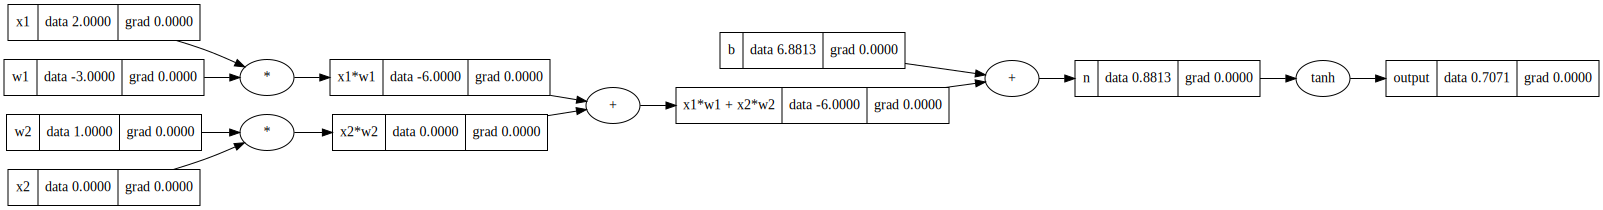

In [8]:
draw_dot(o)

In [9]:
o.backward()

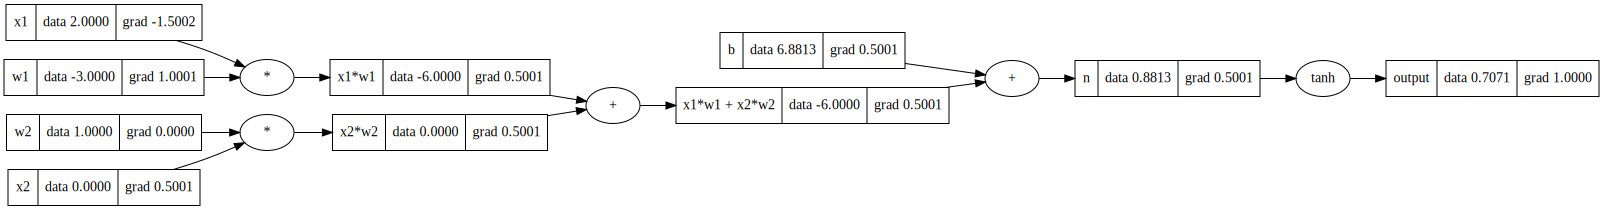

In [10]:
draw_dot(o)

# Using Pytorch

In [11]:
import torch

## Inputs x1 and x2
x1 = torch.tensor([2.0]).double(); x1.requires_grad=True
x2 = torch.tensor([0.0]).double(); x2.requires_grad=True

## Weights W1 and W2
w1 = torch.tensor([-3.0]).double(); w1.requires_grad=True
w2 = torch.tensor([1.0]).double(); w2.requires_grad=True


## Bias the neuron
b = torch.tensor([6.8812735870195432]).double(); b.requires_grad=True

# compute the forward computation (or propagation)
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

# Let's see what we get
print(o.data.item())
o.backward()
print("------------")
print('x1', x1.grad.item())
print('x2', x2.grad.item())
print('w1', w1.grad.item())
print('w2', w2.grad.item())

## THis is the expeced output
# 0.7070568573976658
# ------------
# x1 -1.5002118012208108
# x2 0.500070600406937
# w1 1.000141200813874
# w2 0.0

0.7070568573976658
------------
x1 -1.5002118012208108
x2 0.500070600406937
w1 1.000141200813874
w2 0.0


# Building the MLP

In [29]:
import random

class Neuron:

    def __init__(self, nin): ## nin is the number of inputs
        # step 1: initialize the weights randomly
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        # step 2: intialize the bias randomly
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w*x + b ==> when called, this will be performed,
        # followed by the tanh activation
        summation = self.b
        for wi, xi in zip(self.w, x):
            summation += wi*xi
        out = summation.tanh()
        return out

    def parameters(self):
        # We also need the parameters--this is all the weights
        # and bias putting in a list
        return self.w + [self.b]

class Layer:
    def __init__(self, nin, nout):
        # get all the neurons of this layer
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        # call each neurons in a layer
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neurons in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params

class MLP:
    def __init__(self, nin, nouts):
        # nin is the number of node in input layer, and nouts
        # is the list of layers, each element of that list will
        # have the number of nodes in it
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



In [30]:
network = MLP(3, [4,4,1])
input = [2.0, 3.0, -1.0]
output = network(input); output.label="output"
print(output)

Value(data=-0.8947920056250717, label=output)


# Training a NN

In [31]:
# Dummy input
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

# Dummy output
ys = [1.0, -1.0, -1.0, 1.0]

#running prediction on random weights
ypred = [network(x) for x in xs]
ypred


[Value(data=-0.8947920056250717, label=),
 Value(data=-0.8963422489008429, label=),
 Value(data=-0.8487371629350116, label=),
 Value(data=-0.8108056977250796, label=)]

In [32]:
loss = sum((yout -ygt)**2 for ygt, yout in zip(ys, ypred))
loss.label = "loss"
loss

Value(data=6.902879394734179, label=loss)

In [33]:
steps = []
losses = []
for k in range(20):

    #forward pass
    ypred = [network(x) for x in xs]
    loss = sum((yout -ygt)**2 for ygt, yout in zip(ys, ypred))

    #backward pass
    for p in network.parameters():
        p.grad = 0.0
    loss.backward()

    # update
    for p in network.parameters():
        p.data += -.05*p.grad

    print(k, loss.data)
    steps.append(k)
    losses.append(loss.data)

0 6.902879394734179
1 5.660967970694898
2 3.3666610970934805
3 2.576241300962289
4 1.7124624558357944
5 1.1308250784194958
6 0.4915962939292842
7 0.27210261596332147
8 0.21008950214936714
9 0.16978093357414106
10 0.1416521146433906
11 0.12104962494799043
12 0.10539049644451468
13 0.09313300042075927
14 0.0833054002549184
15 0.0752678021265899
16 0.06858326990191202
17 0.06294418345167736
18 0.05812822389631514
19 0.05397104135533336


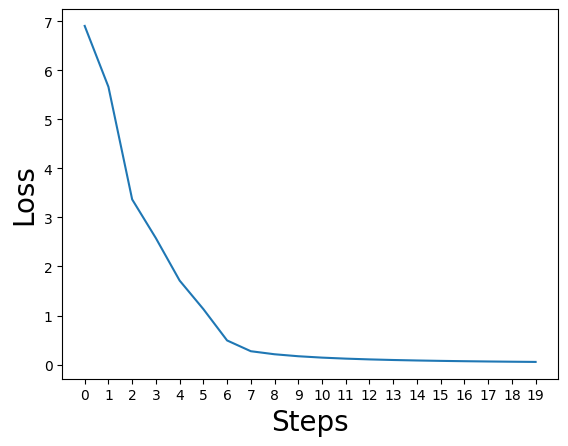

In [43]:
plt.plot(steps, losses)
# plt.grid()
plt.xticks(steps)
plt.xlabel("Steps", fontsize=20)
plt.ylabel("Loss", fontsize=20)
#plt.title("Loss vs Steps")
plt.show()

In [44]:
ypred

[Value(data=0.872001932744575, label=),
 Value(data=-0.8952951207746844, label=),
 Value(data=-0.9031636329156439, label=),
 Value(data=0.868671623742144, label=)]